# Подготовка к обработке данных

## Подключение и преднастройка необходимых компонент

Подключение Google Drive

In [1]:
%%time
# монтируем диск
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CPU times: user 180 ms, sys: 23.3 ms, total: 203 ms
Wall time: 16.5 s


Подключение глобально необходимых библиотек

In [2]:
# для отрисовки графиков
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random as rand

# для объединения в одну модель
from sklearn.pipeline import Pipeline

# для масштабирования
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# модули оценщика
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# для вывода результатов
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

Инициализация константы для random_state

In [3]:
# для повторяемости результатов
SEED = 100

Настройка графиков

In [4]:
# преднастройка графиков
plt.style.use("fivethirtyeight")
sns.set_style('whitegrid')

# чтобы графики были в одном окне
%matplotlib inline

Установка catboost

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 1.9 MB/s eta 0:00:00


## Загрузка датасета

Чтение датасета, чтобы к нему можно было обратиться методами sklearn

In [5]:
# загружаем данные с Google Drive
df = pd.read_csv('/content/drive/MyDrive/Динамические языки программирования/csgo_round_snapshots.csv')

Проверка типов данных столбцов и того, как их интерпретировал pandas

In [6]:
# выводим информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122410 entries, 0 to 122409
Data columns (total 97 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   time_left                     122410 non-null  float64
 1   ct_score                      122410 non-null  float64
 2   t_score                       122410 non-null  float64
 3   map                           122410 non-null  object 
 4   bomb_planted                  122410 non-null  bool   
 5   ct_health                     122410 non-null  float64
 6   t_health                      122410 non-null  float64
 7   ct_armor                      122410 non-null  float64
 8   t_armor                       122410 non-null  float64
 9   ct_money                      122410 non-null  float64
 10  t_money                       122410 non-null  float64
 11  ct_helmets                    122410 non-null  float64
 12  t_helmets                     122410 non-nul

Данный объем данных слишком велик для быстрого обучения моделей ресурсами, бесплатно предоставляемым в Google Colab.
Поэтому разумно ограничить объем выборки

In [7]:
# выбираем случайные 20000 записей со всего датасета
# также задаем random_state для повторяемости результатов
df = df.sample(n=20000, random_state=SEED)

# выводим информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 24403 to 96535
Data columns (total 97 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   time_left                     20000 non-null  float64
 1   ct_score                      20000 non-null  float64
 2   t_score                       20000 non-null  float64
 3   map                           20000 non-null  object 
 4   bomb_planted                  20000 non-null  bool   
 5   ct_health                     20000 non-null  float64
 6   t_health                      20000 non-null  float64
 7   ct_armor                      20000 non-null  float64
 8   t_armor                       20000 non-null  float64
 9   ct_money                      20000 non-null  float64
 10  t_money                       20000 non-null  float64
 11  ct_helmets                    20000 non-null  float64
 12  t_helmets                     20000 non-null  float64
 13  ct

## Анализ датасета

### Проверка статистики

Проверка на наличие отклонений важных характеристик числовых признаков: среднего арифметического, стандартного квадратичного отклонения, перцентилей, а также максимума и минимума

In [8]:
# выводим статистику числовых записей датасета
df.describe()

,time_left,ct_score,t_score,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,...,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.00000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,97.555726,6.690350,6.761400,411.890100,402.536850,315.748700,299.25765,9672.952500,11065.525000,2.062850,...,1.848350,1.862600,1.542800,1.62820,0.99835,0.018900,0.051650,1.357350,0.028550,0.026400
std,54.392799,4.785646,4.790284,132.088451,139.843912,170.820027,174.35937,11242.814121,12174.141508,1.845039,...,1.769494,1.787367,1.731248,1.82237,1.45274,0.139441,0.235128,1.661502,0.171279,0.167345
min,0.060000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,54.920000,3.000000,3.000000,349.000000,322.000000,195.000000,177.00000,1250.000000,1500.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,94.910000,6.000000,6.000000,500.000000,500.000000,380.000000,336.00000,5250.000000,6750.000000,2.000000,...,1.000000,1.000000,1.000000,1.00000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,166.910000,10.000000,10.000000,500.000000,500.000000,486.000000,469.00000,14350.000000,17650.000000,4.000000,...,3.000000,3.000000,3.000000,3.00000,2.00000,0.000000,0.000000,2.000000,0.000000,0.000000
max,175.000000,32.000000,33.000000,500.000000,500.000000,500.000000,500.00000,80000.000000,80000.000000,5.000000,...,6.000000,5.000000,5.000000,5.00000,5.00000,2.000000,3.000000,5.000000,2.000000,2.000000


Уточнение показателей для категориальных данных

In [9]:
# выводим статистику категориальных записей датасета
df.describe(include = [object, 'bool'])

,map,bomb_planted,round_winner
count,20000,20000,20000
unique,8,2,2
top,de_inferno,False,T
freq,3828,17748,10161


Оценка категориальных признаков на наличие артефактов

In [10]:
# итерируемся по столбцам датасета
for name, values in df.items():
  if values.dtype != np.float64:
    print(f"{name}: {df[name].unique()}")

map: ['de_dust2' 'de_overpass' 'de_inferno' 'de_mirage' 'de_nuke' 'de_train'
 'de_vertigo' 'de_cache']
bomb_planted: [False  True]
round_winner: ['T' 'CT']


Проверка статистики по закладке бомб

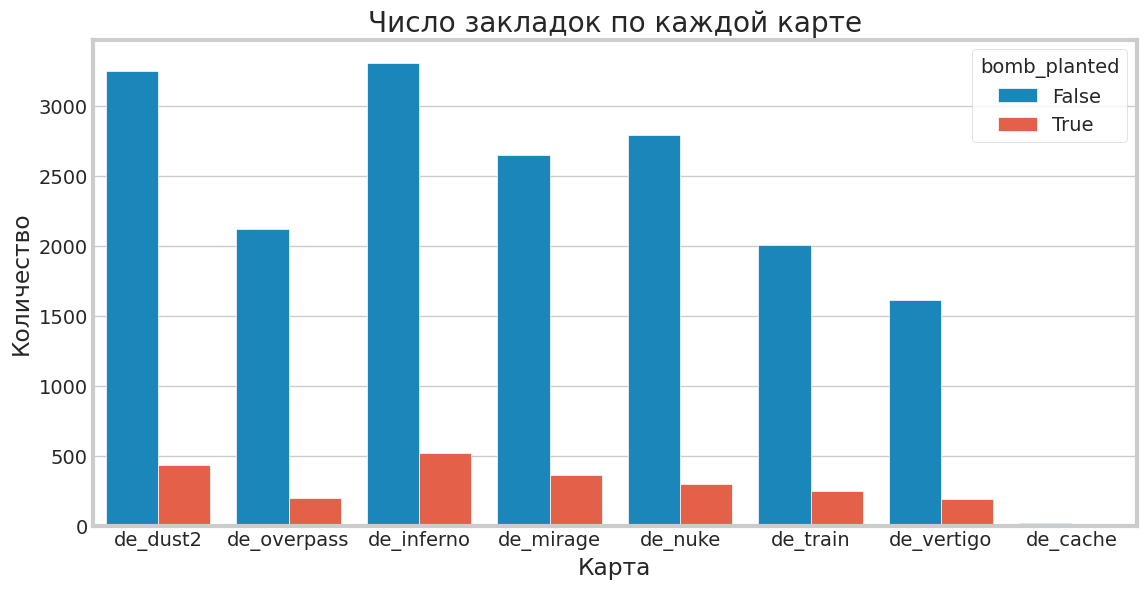

In [11]:
# смотрим число закладок по картам
plt.figure(figsize=(12, 6))
ax = sns.countplot(x="map", hue="bomb_planted", data=df)
ax.set(title='Число закладок по каждой карте', xlabel='Карта', ylabel='Количество')
plt.show()

Проверка статистики по покупке саперных наборов

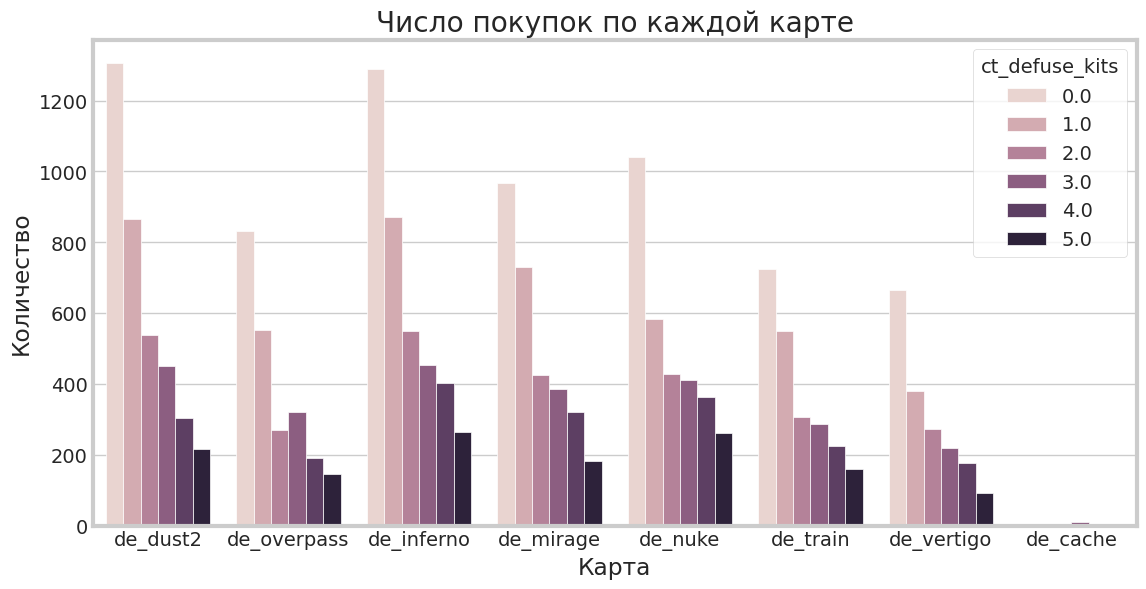

In [12]:
# смотрим количество саперных наборов в команде спецназа по картам
plt.figure(figsize=(12, 6))
ax = sns.countplot(x="map", hue="ct_defuse_kits", data=df)
ax.set(title='Число покупок по каждой карте', xlabel='Карта', ylabel='Количество')
plt.show()

Проверка распределения здоровья игроков

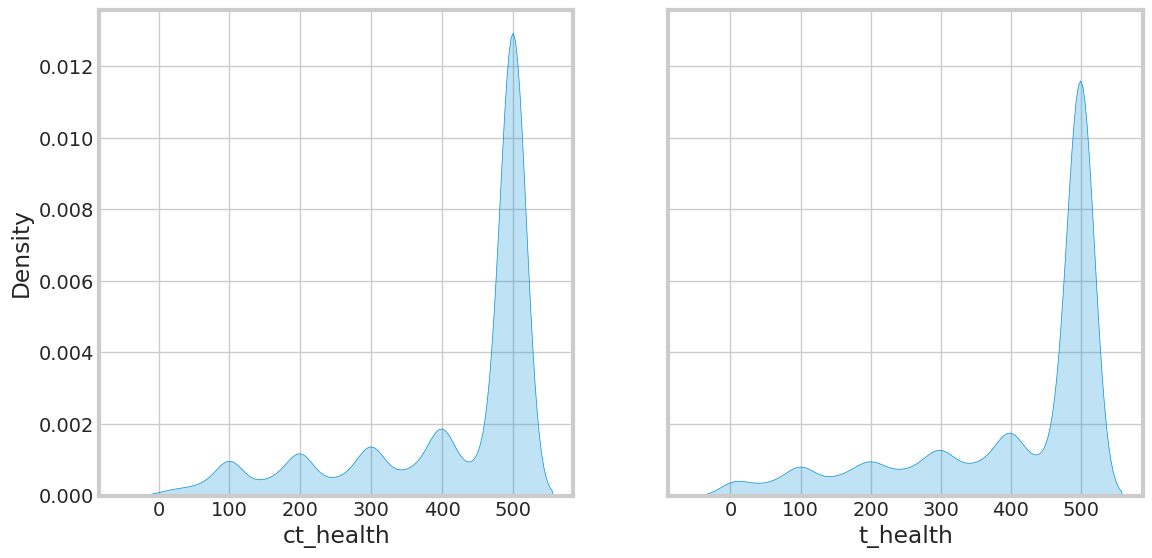

In [13]:
# рисуем распределение здоровья игроков
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,6))
sns.kdeplot(df['ct_health'], fill=True, ax=ax1);
sns.kdeplot(df['t_health'], fill=True, ax=ax2);

Проверка распределения денег по командам

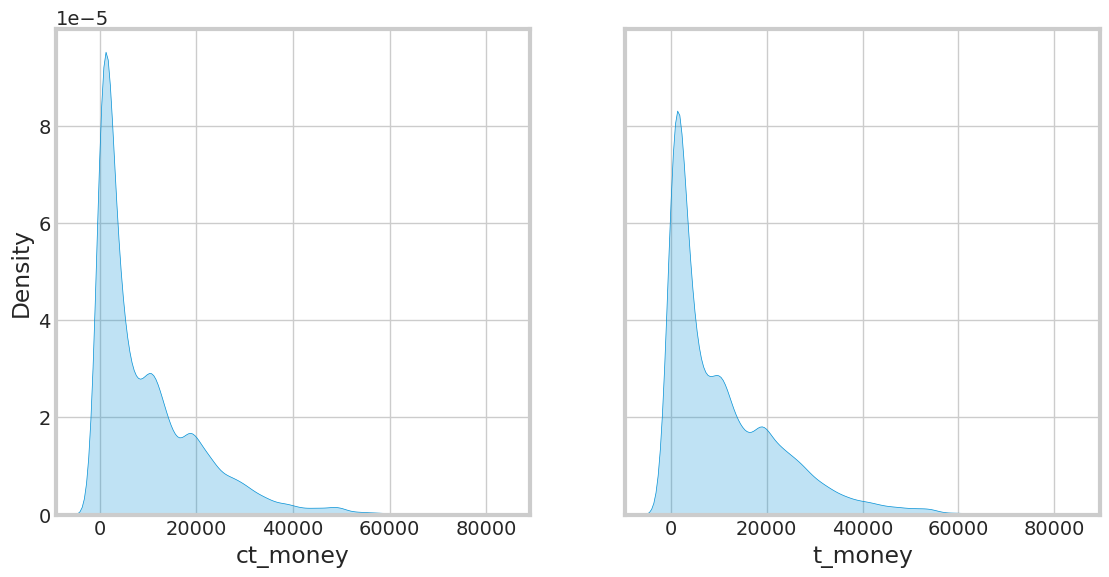

In [14]:
# рисуем распределение денег по командам
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,6))
sns.kdeplot(df['ct_money'], fill=True, ax=ax1);
sns.kdeplot(df['t_money'], fill=True, ax=ax2);

Проверка распределения очков

<Axes: xlabel='t_score', ylabel='Density'>

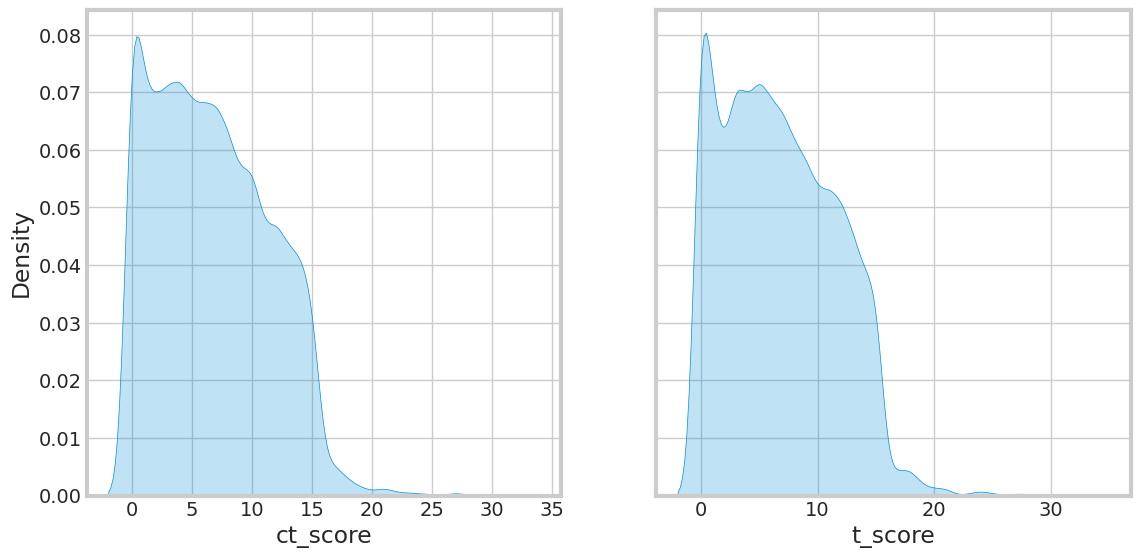

In [15]:
# рисуем распределение очков
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,6))
sns.kdeplot(df['ct_score'], fill=True, ax=ax1)
sns.kdeplot(df['t_score'], fill=True, ax=ax2)

Проверка распределения времени

<Axes: xlabel='time_left', ylabel='Density'>

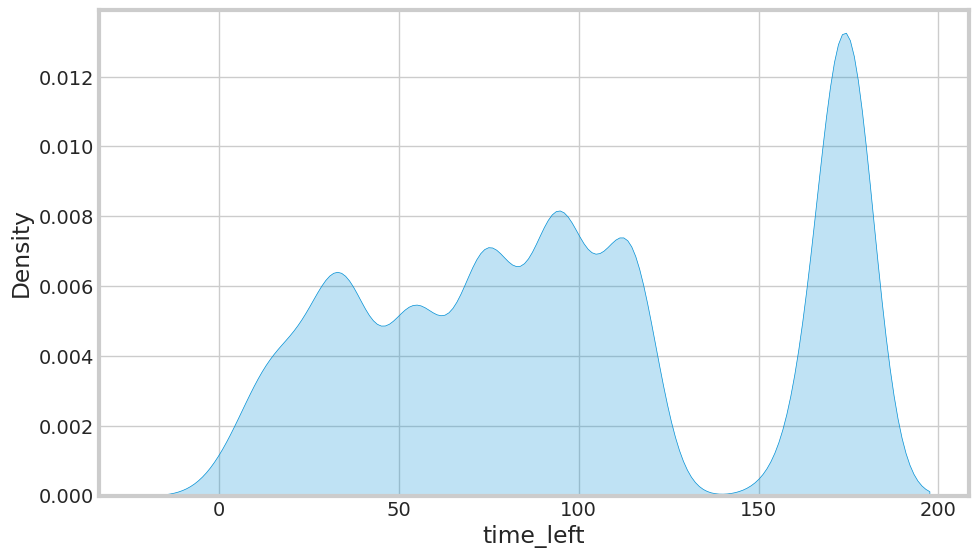

In [16]:
# смотрим распределение времени
plt.figure(figsize=(10,6))
sns.kdeplot(df['time_left'], fill=True)

### Проверка сбалансированности

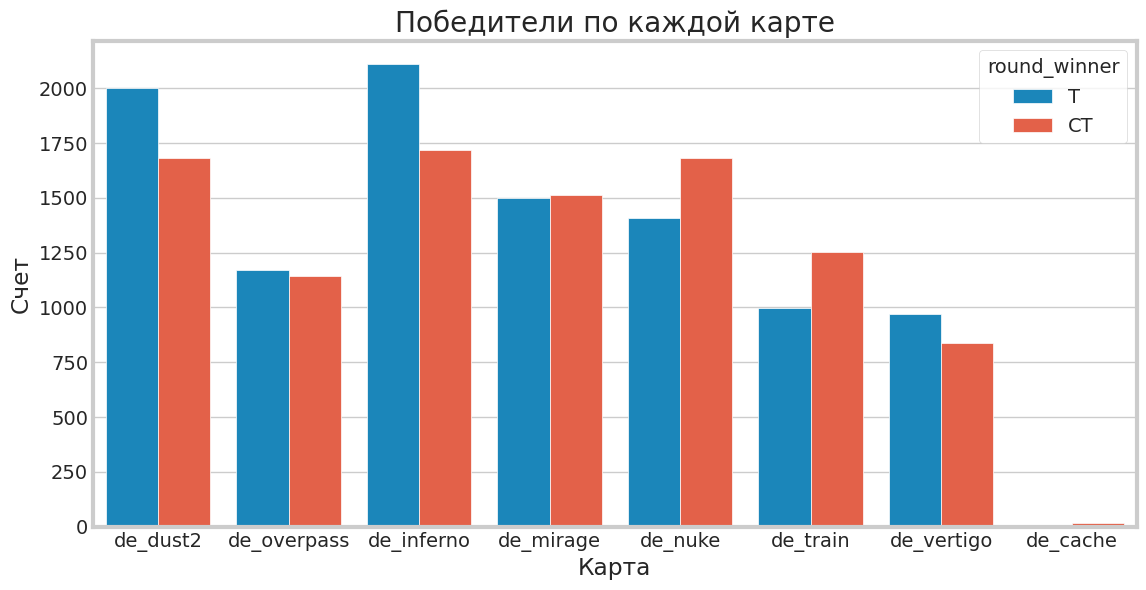

In [17]:
# смотрим счет команд по картам
plt.figure(figsize=(12, 6))
ax = sns.countplot(x="map", hue="round_winner", data=df)
ax.set(title='Победители по каждой карте', xlabel='Карта', ylabel='Счет')
plt.show()

Построение гистограммы распределения целевого признака «round_winner» для проверки сбалансированности

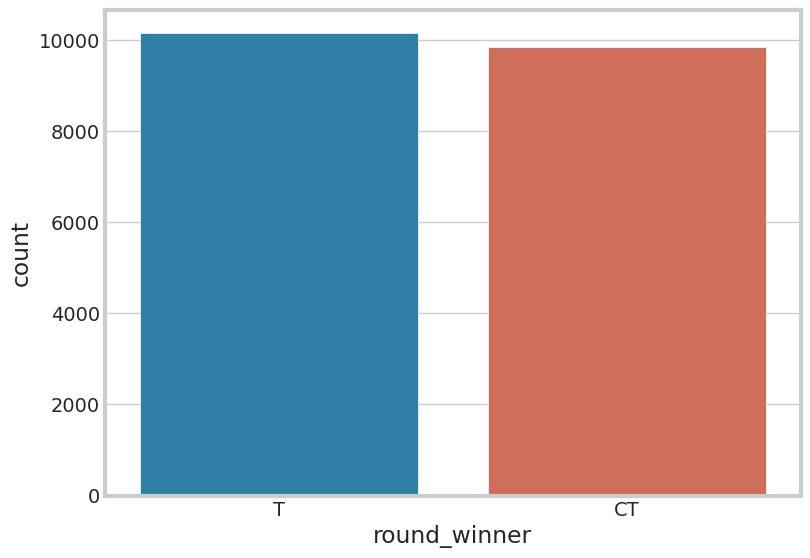

In [18]:
# смотрим общий счет команд
plt.figure(figsize=(8, 6))
sns.countplot(
    data=df,
    x='round_winner',
    hue='round_winner',
    palette=['#1b86ba', '#e36149']
)
plt.show()

На основании приведенных графиков можно сделать вывод о сбалансированности датасета

### Обобщение датасета

Создание обобщенного датасета

In [19]:
"""# функция для определения типа оружия
def categorize_weapon(row):
    pistols = ['ct_weapon_deagle', 'ct_weapon_fiveseven', 'ct_weapon_usps', 'ct_weapon_p250', 'ct_weapon_p2000', 'ct_weapon_tec9']
    rifles = ['ct_weapon_ak47', 'ct_weapon_aug', 'ct_weapon_awp', 'ct_weapon_famas', 'ct_weapon_g3sg1', 'ct_weapon_galilar', 'ct_weapon_m4a1s', 'ct_weapon_m4a4', 'ct_weapon_m249', 'ct_weapon_sg553', 'ct_weapon_ssg08']
    shotguns = ['ct_weapon_nova', 'ct_weapon_sawedoff', 'ct_weapon_xm1014']
    smgs = ['ct_weapon_mac10', 'ct_weapon_mp5sd', 'ct_weapon_mp7', 'ct_weapon_mp9', 'ct_weapon_p90', 'ct_weapon_ump45']
    sniper_rifles = ['ct_weapon_awp', 'ct_weapon_g3sg1', 'ct_weapon_scar20']
    machine_guns = ['ct_weapon_m249', 'ct_weapon_negev']

    ct_weapon_pistols = sum(row[col] for col in pistols)
    ct_weapon_rifles = sum(row[col] for col in rifles)
    ct_weapon_shotguns = sum(row[col] for col in shotguns)
    ct_weapon_smgs = sum(row[col] for col in smgs)
    ct_weapon_sniper_rifles = sum(row[col] for col in sniper_rifles)
    ct_weapon_machine_guns = sum(row[col] for col in machine_guns)

    # аналогично для t_weapons
    t_weapon_pistols = sum(row[col.replace('ct_', 't_')] for col in pistols)
    t_weapon_rifles = sum(row[col.replace('ct_', 't_')] for col in rifles)
    t_weapon_shotguns = sum(row[col.replace('ct_', 't_')] for col in shotguns)
    t_weapon_smgs = sum(row[col.replace('ct_', 't_')] for col in smgs)
    t_weapon_sniper_rifles = sum(row[col.replace('ct_', 't_')] for col in sniper_rifles)
    t_weapon_machine_guns = sum(row[col.replace('ct_', 't_')] for col in machine_guns)

    return pd.Series([ct_weapon_pistols, ct_weapon_rifles, ct_weapon_shotguns, ct_weapon_smgs, ct_weapon_sniper_rifles, ct_weapon_machine_guns,
                      t_weapon_pistols, t_weapon_rifles, t_weapon_shotguns, t_weapon_smgs, t_weapon_sniper_rifles, t_weapon_machine_guns],
                     index=['ct_weapon_pistols', 'ct_weapon_rifles', 'ct_weapon_shotguns', 'ct_weapon_smgs', 'ct_weapon_sniper_rifles', 'ct_weapon_machine_guns',
                            't_weapon_pistols', 't_weapon_rifles', 't_weapon_shotguns', 't_weapon_smgs', 't_weapon_sniper_rifles', 't_weapon_machine_guns'])

grouped_df[['ct_weapon_pistols', 'ct_weapon_rifles', 'ct_weapon_shotguns', 'ct_weapon_smgs', 'ct_weapon_sniper_rifles', 'ct_weapon_machine_guns',
    't_weapon_pistols', 't_weapon_rifles', 't_weapon_shotguns', 't_weapon_smgs', 't_weapon_sniper_rifles', 't_weapon_machine_guns']] = grouped_df.apply(categorize_weapon, axis=1)

# определение списков для категорий оружия
pistols = ['ct_weapon_r8revolver', 't_weapon_r8revolver', 'ct_weapon_glock', 't_weapon_glock', 'ct_weapon_cz75auto', 't_weapon_cz75auto','ct_weapon_deagle', 'ct_weapon_fiveseven', 'ct_weapon_usps', 'ct_weapon_p250', 'ct_weapon_p2000', 'ct_weapon_tec9', 't_weapon_deagle', 't_weapon_fiveseven', 't_weapon_usps', 't_weapon_p250', 't_weapon_p2000', 't_weapon_tec9']
rifles = ['ct_weapon_elite', 't_weapon_elite', 't_weapon_ak47', 't_weapon_aug', 't_weapon_awp', 't_weapon_famas', 't_weapon_g3sg1', 't_weapon_galilar', 't_weapon_m4a1s', 't_weapon_m4a4', 't_weapon_m249', 't_weapon_sg553', 't_weapon_ssg08', 'ct_weapon_ak47', 'ct_weapon_aug', 'ct_weapon_awp', 'ct_weapon_famas', 'ct_weapon_g3sg1', 'ct_weapon_galilar', 'ct_weapon_m4a1s', 'ct_weapon_m4a4', 'ct_weapon_m249', 'ct_weapon_sg553', 'ct_weapon_ssg08']
shotguns = ['ct_weapon_mag7', 't_weapon_mag7', 't_weapon_nova', 't_weapon_sawedoff', 't_weapon_xm1014', 'ct_weapon_nova', 'ct_weapon_sawedoff', 'ct_weapon_xm1014']
smgs = ['t_weapon_mac10', 't_weapon_mp5sd', 't_weapon_mp7', 't_weapon_mp9', 't_weapon_p90', 't_weapon_ump45', 't_weapon_bizon', 'ct_weapon_bizon', 'ct_weapon_mac10', 'ct_weapon_mp5sd', 'ct_weapon_mp7', 'ct_weapon_mp9', 'ct_weapon_p90', 'ct_weapon_ump45']
sniper_rifles = ['t_weapon_awp', 't_weapon_g3sg1', 't_weapon_scar20', 'ct_weapon_awp', 'ct_weapon_g3sg1', 'ct_weapon_scar20']
machine_guns = ['t_weapon_m249', 't_weapon_negev', 'ct_weapon_m249', 'ct_weapon_negev']

grouped_df = grouped_df.drop(columns=pistols + rifles + shotguns + smgs + sniper_rifles + machine_guns)"""

# новый датасет для проверки корелляции
grouped_df = df

# создаем новые столбцы для сумм оружия и гранат для CT и T
grouped_df['ct_weapon'] = df[
    [col for col in df.columns if col.startswith('ct_weapon_')]].sum(axis=1)
grouped_df['t_weapon'] = df[
    [col for col in df.columns if col.startswith('t_weapon_')]].sum(axis=1)
grouped_df['ct_grenade'] = df[
    [col for col in df.columns if col.startswith('ct_grenade_')]].sum(axis=1)
grouped_df['t_grenade'] = df[
    [col for col in df.columns if col.startswith('t_grenade_')]].sum(axis=1)

# удаляем старые столбцы
grouped_df = grouped_df.drop([col for col in df.columns if col.startswith((
    'ct_weapon_', 't_weapon_', 'ct_grenade_', 't_grenade_'))], axis=1)

# выводим получившуюся структуру
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 24403 to 96535
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time_left         20000 non-null  float64
 1   ct_score          20000 non-null  float64
 2   t_score           20000 non-null  float64
 3   map               20000 non-null  object 
 4   bomb_planted      20000 non-null  bool   
 5   ct_health         20000 non-null  float64
 6   t_health          20000 non-null  float64
 7   ct_armor          20000 non-null  float64
 8   t_armor           20000 non-null  float64
 9   ct_money          20000 non-null  float64
 10  t_money           20000 non-null  float64
 11  ct_helmets        20000 non-null  float64
 12  t_helmets         20000 non-null  float64
 13  ct_defuse_kits    20000 non-null  float64
 14  ct_players_alive  20000 non-null  float64
 15  t_players_alive   20000 non-null  float64
 16  round_winner      20000 non-null  object 

Прямое преобразование категориальных признаков в числовые

In [20]:
# переведем категориальный признак «map» в числовой
map_new = {
    'de_dust2' : 1,
    'de_mirage' : 2,
    'de_nuke': 3,
    'de_inferno': 4,
    'de_overpass': 5,
    'de_vertigo': 6,
    'de_train': 7,
    'de_cache': 8
}

grouped_df['map'] = grouped_df['map'].map(map_new).astype('uint8')

# переведем категориальный признак «bomb_planted» в числовой
bomb_planted_new = {
    False : 0,
    True : 1,
}

grouped_df['bomb_planted'] = grouped_df['bomb_planted'].map(bomb_planted_new).astype('uint8')

# переведем категориальный признак «round_winner» в числовой
round_winner_new = {
    'CT' : 0,
    'T' : 1,
}

grouped_df['round_winner'] = grouped_df['round_winner'].map(round_winner_new).astype('uint8')

Вывод случайной записи

In [21]:
# на всякий случай проверяем случайную запись
sample_index = rand.randint(0, len(grouped_df.round_winner) - 1)
print(grouped_df.iloc[sample_index])

time_left             170.0
ct_score                0.0
t_score                 2.0
map                     4.0
bomb_planted            0.0
ct_health             500.0
t_health              500.0
ct_armor              100.0
t_armor               142.0
ct_money            13750.0
t_money             19700.0
ct_helmets              1.0
t_helmets               2.0
ct_defuse_kits          0.0
ct_players_alive        5.0
t_players_alive         5.0
round_winner            1.0
ct_weapon               5.0
t_weapon                7.0
ct_grenade              0.0
t_grenade               3.0
Name: 49781, dtype: float64


### Проверка на наличие незначащих признаков

Проверка корреляции признаков

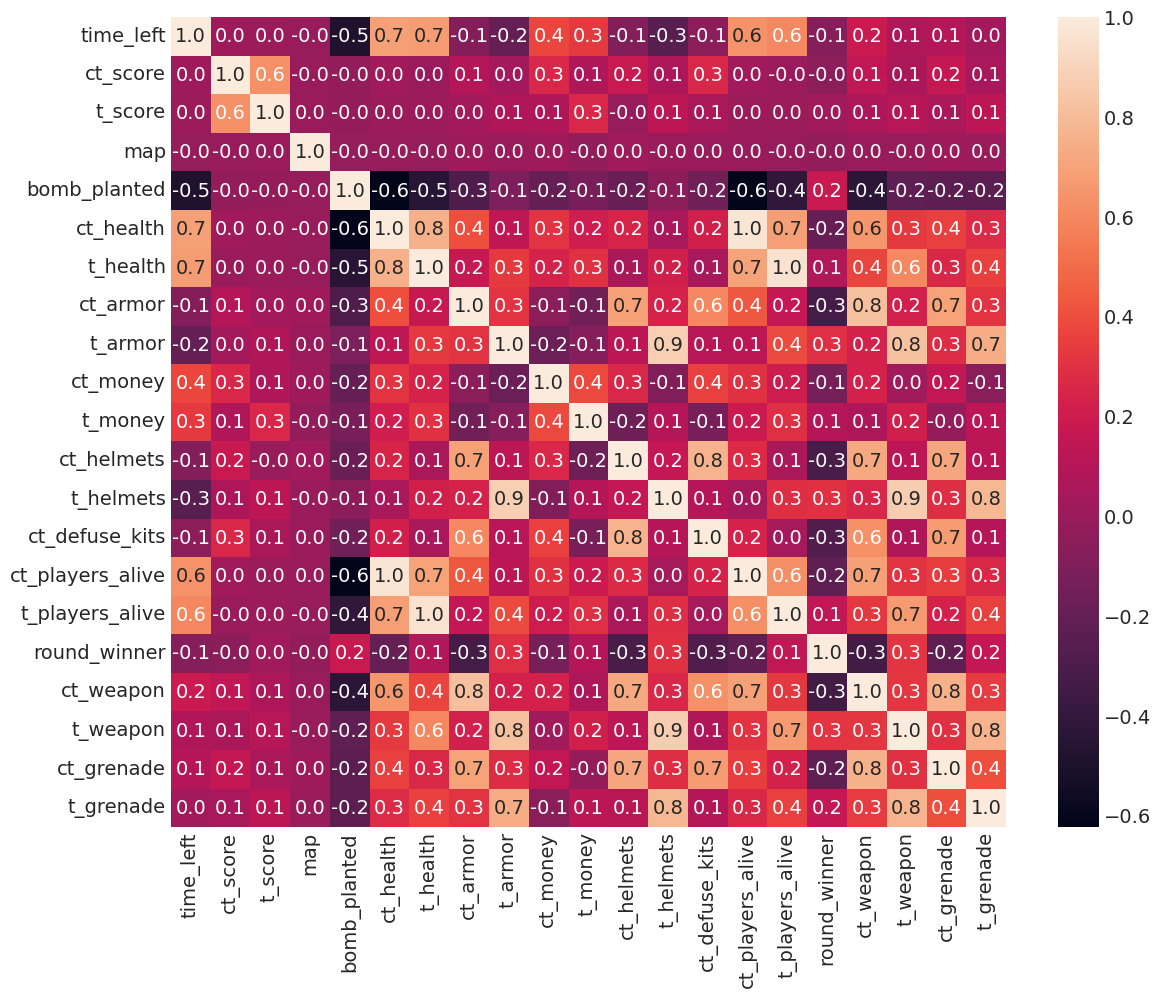

In [22]:
# размер графика
plt.figure(figsize=(12, 10))

# таблица корреляции
sns.heatmap(grouped_df.corr(), annot=True, fmt=".1f");

Удаляем незначащий признак map

In [23]:
# удаляем ненужные столбцы
grouped_df = grouped_df.drop(['map'], axis=1)

# проверяем
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 24403 to 96535
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time_left         20000 non-null  float64
 1   ct_score          20000 non-null  float64
 2   t_score           20000 non-null  float64
 3   bomb_planted      20000 non-null  uint8  
 4   ct_health         20000 non-null  float64
 5   t_health          20000 non-null  float64
 6   ct_armor          20000 non-null  float64
 7   t_armor           20000 non-null  float64
 8   ct_money          20000 non-null  float64
 9   t_money           20000 non-null  float64
 10  ct_helmets        20000 non-null  float64
 11  t_helmets         20000 non-null  float64
 12  ct_defuse_kits    20000 non-null  float64
 13  ct_players_alive  20000 non-null  float64
 14  t_players_alive   20000 non-null  float64
 15  round_winner      20000 non-null  uint8  
 16  ct_weapon         20000 non-null  float64

## Подготовка данных

### Заполнение отсутствующих значений

Проверка на наличие пропусков

In [24]:
# отдельно считаем количество пустых записей в столбцах
skips_num = grouped_df.isna().sum()

print(f"Пропуски по столбцам:\n{skips_num}\n")

# выводим сумму по столбцам
print(f"Всего пропусков: {skips_num.sum()}")

Пропуски по столбцам:
time_left           0
ct_score            0
t_score             0
bomb_planted        0
ct_health           0
t_health            0
ct_armor            0
t_armor             0
ct_money            0
t_money             0
ct_helmets          0
t_helmets           0
ct_defuse_kits      0
ct_players_alive    0
t_players_alive     0
round_winner        0
ct_weapon           0
t_weapon            0
ct_grenade          0
t_grenade           0
dtype: int64

Всего пропусков: 0


### Выбор обучающего и тестового наборов

Разделение данных на те, по которым предсказываем, и на те, которые предсказываем

In [25]:
# выбираем целевой признак
y_df = grouped_df.round_winner
# выбираем остальные признаки
X_df = grouped_df.drop(['round_winner'], axis=1)

"""# уберем малозначимые факторы
cols_grenade = 'grenade'
X_df = X_df.drop(X_df.columns[X_df.columns.str.contains(cols_grenade)], axis=1)
"""

# выводим на всякий случай
X_df.head()

,time_left,ct_score,t_score,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon,t_weapon,ct_grenade,t_grenade
24403,47.95,5.0,7.0,0,284.0,500.0,100.0,417.0,7700.0,39050.0,0.0,5.0,0.0,4.0,5.0,4.0,10.0,0.0,15.0
29424,34.94,5.0,11.0,0,296.0,170.0,350.0,100.0,800.0,1050.0,2.0,1.0,0.0,4.0,2.0,8.0,2.0,2.0,0.0
94260,20.11,7.0,2.0,1,200.0,157.0,200.0,189.0,5450.0,4900.0,1.0,0.0,1.0,2.0,2.0,4.0,4.0,1.0,1.0
59597,18.01,0.0,0.0,1,100.0,335.0,100.0,177.0,150.0,1500.0,0.0,0.0,0.0,1.0,4.0,1.0,4.0,0.0,0.0
103114,37.65,7.0,3.0,1,100.0,368.0,100.0,388.0,900.0,1650.0,1.0,4.0,1.0,1.0,4.0,2.0,8.0,0.0,1.0


Выделяем обучающую и тестовую выборки

In [26]:
# разделяем выборку
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y_df, test_size = 0.2, random_state=SEED)

### Масштабирование признаков

Выбираем тип масштабирования

In [27]:
# выбираем тип scaler'а
scaler = StandardScaler()

# скалируем
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# проверяем
X_train

array([[-0.41097568,  0.69649692,  0.47254564, ..., -1.89520559,
         0.10456551, -0.98256133],
       [-1.07945293, -0.14128388,  0.47254564, ..., -0.76066332,
        -0.94711483, -0.98256133],
       [-0.04322112, -0.97906467, -1.40818104, ...,  1.13024046,
         0.27984557,  0.67059665],
       ...,
       [-1.51589675, -0.14128388,  1.09945453, ..., -1.89520559,
         0.27984557, -0.79887711],
       [-0.78222916, -1.39795507, -1.40818104, ..., -0.76066332,
        -0.94711483, -0.98256133],
       [-0.87854145,  0.48705172, -1.19921141, ..., -1.89520559,
        -0.42127466, -0.61519289]])

# **ЛР1**

## Описание

Задание 1. Найти набор данных (датасет) для классификации удовлетворяющий следующим условиям: более 10 000 строк, более 20 столбцов, разные типы в столбцах, обязательно наличие целевого признака (таргета).
<br>
Задание 2 . Провести классификацию найденного датасета, методом к- ближайших соседей. В формате *Markdown* писать пояснения. Объяснить почему были выбраны именно такие гиперпараметры, была ли перекрестная проверка, и т.д.
<br><br>
P.S. Все решения выполнять в формате *Jupyter Notebook* и выкладывать на свои гитхабы.


## Решение

### Выбор датасета

На основании приведенных в описании 1 лаборатоной работы критериев, был выбран датасет по матчам компьютерной игры CS:GO. Целью работы является выявление победителя на основании заранее заданных параметров. Целевой показатель при этом может принимать 2 значения: победа команды террористов («T») или победа команды спецназа («CT»). Ссылка на используемый датасет приведена далее: https://www.kaggle.com/datasets/christianlillelund/csgo-round-winner-classification

### Подключение модулей

In [28]:
# стандартный модуль KNN
from sklearn.neighbors import KNeighborsClassifier

### **sklearn.neighbors.KNeighborsClassifier**

---



#### По-умолчанию

Проверка модели с гиперпараметрами по-умолчанию

In [29]:
%%time

"""# создание пайплайна
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])"""

# создаем модель
knn = KNeighborsClassifier()

# подаем на вход модели обучающие данные
knn.fit(X_train, y_train)

CPU times: user 3.97 ms, sys: 0 ns, total: 3.97 ms
Wall time: 3.98 ms


KNeighborsClassifier()

Вывод результатов

In [30]:
# предсказываем результат на тестовой выборке
knn_pred = knn.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, knn_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, knn_pred)}\n')

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.74      0.75      0.75      1963
           1       0.76      0.74      0.75      2037

    accuracy                           0.75      4000
   macro avg       0.75      0.75      0.75      4000
weighted avg       0.75      0.75      0.75      4000


Матрица ошибок: 
[[1480  483]
 [ 523 1514]]



#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [31]:
%%time

# задаем диапазон параметров
# количество соседей
k_range = [3, 5, 7, 9, 11, 13, 15]
# сравним три стандартных алгоритма knn в sklearn
algorithms = ['ball_tree', 'kd_tree', 'brute']
# метрики расстояния в пространстве признаков
metrics = [
    'euclidean',
    'manhattan',
    'minkowski',
    'chebyshev',
    'hamming',
    'canberra',
    'braycurtis'
]

parameters = {
    'n_neighbors': k_range, # число учитываемых соседей
    'algorithm': algorithms, # алгоритмы поиска соседей
    'weights': ['uniform', 'distance'], # веса соседей
    'leaf_size': [10, 20, 30, 40], # размер листа, используемый в BallTree или KDTree
    'metric': metrics, # метрики расстояния
}

# подбираем лучшие параметры
grid_knn = RandomizedSearchCV(
    KNeighborsClassifier(),
    parameters,
    scoring='f1',
    n_jobs = -1
)

# обучаем модель
grid_knn.fit(X_train, y_train)

CPU times: user 822 ms, sys: 201 ms, total: 1.02 s
Wall time: 1min 10s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 215, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py", line 493, in _fit
    self._check_algorithm_metric()
  File "/usr/local/lib/python3.10/dist-packages/sklearn

RandomizedSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'algorithm': ['ball_tree', 'kd_tree',
                                                      'brute'],
                                        'leaf_size': [10, 20, 30, 40],
                                        'metric': ['euclidean', 'manhattan',
                                                   'minkowski', 'chebyshev',
                                                   'hamming', 'canberra',
                                                   'braycurtis'],
                                        'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
                                        'weights': ['uniform', 'distance']},
                   scoring='f1')

Вывод результата кросс-валидации

In [32]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_knn.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_knn.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_knn_pred = grid_knn.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_knn_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_knn_pred)}\n')

Лучшие параметры:
{'weights': 'distance', 'n_neighbors': 9, 'metric': 'euclidean', 'leaf_size': 20, 'algorithm': 'brute'}

Показатель f1 для лучшей модели составил: 75.23%

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.75      0.77      0.76      1963
           1       0.77      0.76      0.76      2037

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000


Матрица ошибок: 
[[1502  461]
 [ 491 1546]]



# **ЛР2**

## Описание

Задание 1 . Провести классификацию найденного датасета, методом машины опорных векторов. В формате *Markdown* писать пояснения. Объяснить почему были выбраны именно такие гиперпараметры, была ли перекрестная проверка, и т.д.
<br><br>
P.S. Все решения выполнять в формате *Jupyter Notebook* и выкладывать на свои гитхабы.

## Решение

### Подключение модулей

Метод машины опорных векторов

In [33]:
# общий модуль для бинарной и многоклассовой классификации
from sklearn.svm import SVC

# специализированный модуль для классификации с линейным ядром
from sklearn.svm import LinearSVC

# модуль для обучения регуляризованных линейных моделей по стохастическому
# градиентному спуску. По-умолчанию обучает линейный SVM
from sklearn.linear_model import SGDClassifier

### **sklearn.linear_model.SGDClassifier**

---



#### По-умолчанию

Создание и обучение модели

In [34]:
%%time

# создаем модель
svm_sgdc = SGDClassifier()

# подаем на вход модели обучающие данные
svm_sgdc.fit(X_train, y_train)

CPU times: user 168 ms, sys: 2.48 ms, total: 170 ms
Wall time: 505 ms


SGDClassifier()

Вывод результата

In [35]:
# предсказываем результат на тестовой выборке
svm_sgdc_pred = svm_sgdc.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, svm_sgdc_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, svm_sgdc_pred)}\n')

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.75      0.69      0.72      1963
           1       0.72      0.78      0.75      2037

    accuracy                           0.74      4000
   macro avg       0.74      0.74      0.74      4000
weighted avg       0.74      0.74      0.74      4000


Матрица ошибок: 
[[1354  609]
 [ 441 1596]]



#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [36]:
%%time

# задаем параметры
parameters = {
    'penalty': ['none', 'l2', 'l1', 'elasticnet'], # тип регуляризации
    'alpha': [0.001, 0.01, 0.1, 1], # коэффициент регуляризации
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'], # стратегия изменения скорости обучения
    'eta0': [0.01, 0.1, 0.2, 0.5], # начальная скорость обучения
    'fit_intercept': [True, False], # следует ли добавлять константный член в линейную модель
    'tol': [1e-3, 1e-4, 1e-5], # пороговое значение для оптимизации
    'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron'], # функция потерь
    'l1_ratio': [0.0, 0.25, 0.5, 0.75, 1.0], # коэффициент для смешивания L1 и L2 регуляризации
    'average': [True, False] # следует ли усреднять веса классов
}

# подбираем лучшие параметры
grid_svm_sgdc = RandomizedSearchCV(
    SGDClassifier(),
    parameters,
    scoring='f1',
    n_jobs = -1
)
# обучаем модель
grid_svm_sgdc.fit(X_train, y_train)

CPU times: user 254 ms, sys: 29.1 ms, total: 284 ms
Wall time: 6.23 s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 891, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packa

RandomizedSearchCV(estimator=SGDClassifier(), n_jobs=-1,
                   param_distributions={'alpha': [0.001, 0.01, 0.1, 1],
                                        'average': [True, False],
                                        'eta0': [0.01, 0.1, 0.2, 0.5],
                                        'fit_intercept': [True, False],
                                        'l1_ratio': [0.0, 0.25, 0.5, 0.75, 1.0],
                                        'learning_rate': ['constant', 'optimal',
                                                          'invscaling',
                                                          'adaptive'],
                                        'loss': ['hinge', 'log_loss',
                                                 'modified_huber',
                                                 'squared_hinge',
                                                 'perceptron'],
                                        'penalty': ['none', 'l2', 'l1',
                                                    'elasticnet'],
                                        'tol': [0.001, 0.0001, 1e-05]},
                   scoring='f1')

Вывод результата кросс-валидации

In [37]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_svm_sgdc.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_svm_sgdc.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_svm_sgdc_pred = grid_svm_sgdc.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_svm_sgdc_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_svm_sgdc_pred)}\n')

Лучшие параметры:
{'tol': 0.0001, 'penalty': 'l2', 'loss': 'modified_huber', 'learning_rate': 'invscaling', 'l1_ratio': 0.5, 'fit_intercept': True, 'eta0': 0.01, 'average': True, 'alpha': 0.1}

Показатель f1 для лучшей модели составил: 74.31%

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.74      0.77      0.76      1963
           1       0.77      0.74      0.76      2037

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000


Матрица ошибок: 
[[1509  454]
 [ 521 1516]]



### **sklearn.svm.SVC**

---

#### По-умолчанию

Создание и обучение модели

In [38]:
%%time

# создаем модель
svm_svc = SVC()

# подаем на вход модели обучающие данные
svm_svc.fit(X_train, y_train)

CPU times: user 11.3 s, sys: 341 ms, total: 11.6 s
Wall time: 15.4 s


SVC()

Вывод результата

In [39]:
# предсказываем результат на тестовой выборке
svm_svc_pred = svm_svc.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, svm_svc_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, svm_svc_pred)}\n')

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.72      0.84      0.78      1963
           1       0.82      0.69      0.75      2037

    accuracy                           0.76      4000
   macro avg       0.77      0.76      0.76      4000
weighted avg       0.77      0.76      0.76      4000


Матрица ошибок: 
[[1650  313]
 [ 635 1402]]



#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [49]:
%%time

# задаем гиперпараметры
parameters = {
    'C': [0.1, 1], # коэффициент регуляризации
    'kernel': ['poly', 'rbf', 'sigmoid'], # тип ядра
    'degree': [4] # степень для 'poly' ядра
    #'gamma': ['scale', 'auto'], # коэффициент ядра для 'rbf', 'poly' и 'sigmoid'
    #'coef0': [0.0, 0.5, 1.0], # смещение для 'poly' и 'sigmoid'
    #'tol': [1e-3, 1e-4], # пороговое значение для оптимизации
    #'class_weight': [None, 'balanced'], # веса классов
}

# подбираем лучшие параметры
grid_svm_svc = RandomizedSearchCV(
    SVC(),
    parameters,
    scoring='f1',
    n_jobs = -1
)

# обучаем модель
grid_svm_svc.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


CPU times: user 12 s, sys: 444 ms, total: 12.4 s
Wall time: 4min 6s


RandomizedSearchCV(estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': [0.1, 1],
                                        'kernel': ['poly', 'rbf', 'sigmoid']},
                   scoring='f1')

Вывод результата кросс-валидации

In [50]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_svm_svc.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_svm_svc.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_svm_svc_pred = grid_svm_svc.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_svm_svc_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_svm_svc_pred)}\n')

Лучшие параметры:
{'kernel': 'poly', 'C': 0.1}

Показатель f1 для лучшей модели составил: 73.70%

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.73      0.81      0.77      1963
           1       0.80      0.71      0.75      2037

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000


Матрица ошибок: 
[[1598  365]
 [ 594 1443]]



### **sklearn.svm.LinearSVC**

---

#### По-умолчанию

Создание и обучение модели

In [42]:
%%time

# создаем модель
svm_lsvc = LinearSVC()

# подаем на вход модели обучающие данные
svm_lsvc.fit(X_train, y_train)

CPU times: user 2.83 s, sys: 3.92 ms, total: 2.84 s
Wall time: 2.86 s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

Вывод результата

In [43]:
# предсказываем результат на тестовой выборке
svm_lsvc_pred = svm_lsvc.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, svm_lsvc_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, svm_lsvc_pred)}\n')

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.73      0.76      0.75      1963
           1       0.76      0.73      0.75      2037

    accuracy                           0.75      4000
   macro avg       0.75      0.75      0.75      4000
weighted avg       0.75      0.75      0.75      4000


Матрица ошибок: 
[[1494  469]
 [ 546 1491]]



#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [44]:
%%time

# задаем диапазон параметров
parameters = {
    #'penalty': ['l1', 'l2'], # тип регуляризации, l2 по-умолчанию
                             # l1 приводит к разреженным _coef
    'loss': ['hinge', 'squared_hinge'], # функция потерь
                                        # проверяем обе
    #'dual': [True, False], # следует ли использовать двойственную форму задачи, True по-умолчанию
                            # поскольку n_samples > n_features, берем двойственную
    'tol': [1e-4, 1e-3], # пороговое значение для оптимизации, 1e-3 по-умолчанию
    'C': [10], # коэффициент регуляризации
               # проверяем методом научного тыка
    #'fit_intercept': [True, False], # следует ли добавлять константный член (центрирование)
                                     # True по-умолчанию
    'intercept_scaling': [1, 10, 100], # масштабирование константного члена
    #'class_weight': [None, 'balanced'] # веса классов
}

# подбираем лучшие параметры
grid_svm_lsvc = RandomizedSearchCV(LinearSVC(), parameters, scoring='f1', n_jobs=-1)
# обучаем модель
grid_svm_lsvc.fit(X_train, y_train)

CPU times: user 1.04 s, sys: 161 ms, total: 1.21 s
Wall time: 1min 13s


RandomizedSearchCV(estimator=LinearSVC(), n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10],
                                        'intercept_scaling': [1, 10, 100],
                                        'loss': ['hinge', 'squared_hinge'],
                                        'tol': [0.0001, 0.001]},
                   scoring='f1')

Вывод результата кросс-валидации

In [45]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_svm_lsvc.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_svm_lsvc.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_svm_lsvc_pred = grid_svm_lsvc.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_svm_lsvc_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_svm_lsvc_pred)}\n')

Лучшие параметры:
{'tol': 0.0001, 'loss': 'squared_hinge', 'intercept_scaling': 10, 'C': 0.01}

Показатель f1 для лучшей модели составил: 73.98%

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.73      0.76      0.75      1963
           1       0.76      0.73      0.75      2037

    accuracy                           0.75      4000
   macro avg       0.75      0.75      0.75      4000
weighted avg       0.75      0.75      0.75      4000


Матрица ошибок: 
[[1498  465]
 [ 547 1490]]



# **ЛР3**

## Описание

Задание 1 . Провести классификацию найденного датасета, методами линеной и логистической регрессий . В формате *Markdown* написать пояснения. Объяснить почему были выбраны именно такие гиперпараметры, была ли перекрестная проверка, и т.д.
<br><br>
P.S. Все решения выполнять в формате *Jupyter Notebook* и выкладывать на свои гитхабы.

## Решение

### Подключение модулей

Методы линейной регрессии

In [51]:
# стандартная модель
from sklearn.linear_model import LinearRegression

# для комбинированных L1- и L2-регуляризаций
from sklearn.linear_model import ElasticNet

# для L1-регуляризации
from sklearn.linear_model import Lasso

# для L2-регуляризации
from sklearn.linear_model import Ridge

# для стохастического градиентного спуска
from sklearn.linear_model import SGDRegressor

Методы логистической регрессии

In [52]:
# стандартная модель, поддерживающая бинарную, One-vs-Rest и мультиномиальную
# логистическую регрессию с опциональной регуляризацией L1, L2 или Elastic-Net
from sklearn.linear_model import LogisticRegression

### **sklearn.linear_model.LinearRegression**

---



#### Проверка обычной регрессии

Создание и обучение модели

In [53]:
%%time

# создаем модель
regression_linear = LinearRegression()

# подаем на вход модели обучающие данные
regression_linear.fit(X_train, y_train)

CPU times: user 22.3 ms, sys: 1.83 ms, total: 24.1 ms
Wall time: 53.2 ms


LinearRegression()

Вывод результата

In [54]:
# предсказываем результат на тестовой выборке
regression_linear_pred = regression_linear.predict(X_test)

# заводим переменные
mae = mean_absolute_error(y_test, regression_linear_pred)
mse = mean_squared_error(y_test, regression_linear_pred)

# оцениваем модель
print(f'MAE: {mae:.5f}')
print(f'MSE: {mse:.5f}')
print(f'RMSE: {np.sqrt(mse):.5f}')

MAE: 0.34933
MSE: 0.16386
RMSE: 0.40479


### **sklearn.linear_model.LogisticRegression**

---



#### По-умолчанию

Создание и обучение модели

In [55]:
%%time

# создаем модель
regression_logistic = LogisticRegression()

# подаем на вход модели обучающие данные
regression_logistic.fit(X_train, y_train)

CPU times: user 131 ms, sys: 65.6 ms, total: 197 ms
Wall time: 109 ms


LogisticRegression()

Вывод результата

In [56]:
# предсказываем результат на тестовой выборке
regression_logistic_pred = regression_logistic.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, regression_logistic_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, regression_logistic_pred)}\n')

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.73      0.76      0.74      1963
           1       0.76      0.73      0.75      2037

    accuracy                           0.74      4000
   macro avg       0.74      0.74      0.74      4000
weighted avg       0.74      0.74      0.74      4000


Матрица ошибок: 
[[1485  478]
 [ 544 1493]]



#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [72]:
%%time

# задаем диапазон параметров
parameters = {
    'penalty': ['l1', 'l2'], # тип регуляризации
    'C': [0.001, 0.01, 0.1, 1, 10], # инверсное значение коэффициента регуляризации
    #'fit_intercept': [True, False], # следует ли добавлять константный член в линейную модель
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], # алгоритм оптимизации
    #'tol': [1e-4, 1e-3], # пороговое значение для оптимизации
    #'class_weight': [None, 'balanced'] # веса классов
}

# подбираем лучшие параметры
grid_regression_logistic = RandomizedSearchCV(
    LogisticRegression(),
    parameters,
    scoring='f1',
    n_jobs = -1
)
# обучаем модель
grid_regression_logistic.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver

CPU times: user 462 ms, sys: 83.8 ms, total: 546 ms
Wall time: 10.6 s


RandomizedSearchCV(estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   scoring='f1')

Вывод результата кросс-валидации

In [73]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_regression_logistic.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_regression_logistic.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_regression_logistic_pred = grid_regression_logistic.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_regression_logistic_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_regression_logistic_pred)}\n')

Лучшие параметры:
{'solver': 'sag', 'penalty': 'l2', 'C': 0.01}

Показатель f1 для лучшей модели составил: 74.44%

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.74      0.76      0.75      1963
           1       0.76      0.74      0.75      2037

    accuracy                           0.75      4000
   macro avg       0.75      0.75      0.75      4000
weighted avg       0.75      0.75      0.75      4000


Матрица ошибок: 
[[1496  467]
 [ 533 1504]]



# **ЛР4**


## Описание

Задание 1 . Провести классификацию найденного датасета, методами наивного Байеса  . В формате *Markdown* написать пояснения. Объяснить почему были выбраны именно такие гиперпараметры, была ли перекрестная проверка, и т.д.
<br><br>
P.S. Все решения выполнять в формате *Jupyter Notebook* и выкладывать на свои гитхабы.

## Решение

### Подключение модулей

In [74]:
# гауссовский наивный байесовский алгоритм для классификации
# когда вероятность появления признаков Гауссова
from sklearn.naive_bayes import GaussianNB

# для классификации текстовых документов, где признаки представляют собой частоты слов
from sklearn.naive_bayes import MultinomialNB

# для работы с бинарными признаками
from sklearn.naive_bayes import ComplementNB

# обобщение наивного байесовского классификатора, учитывающее
# дополнительные сведения о распределении признаков
from sklearn.naive_bayes import BernoulliNB

# для работы с категориальными признаками
from sklearn.naive_bayes import CategoricalNB

### **sklearn.naive_bayes.GaussianNB**

---



#### Обычная байесовская модель

Создание и обучение модели

In [75]:
%%time

# вероятности классов - единственный параметр GaussianNB
# priors по-умолчанию None (вычисляются на основе входных данных)
"""parameters = {'priors': [None]}"""

# создаем модель
nb_gaussian = GaussianNB()

# подаем на вход модели обучающие данные
nb_gaussian.fit(X_train, y_train)

CPU times: user 13.6 ms, sys: 831 µs, total: 14.5 ms
Wall time: 23.3 ms


GaussianNB()

Вывод результата

In [76]:
# предсказываем результат на тестовой выборке
nb_gaussian_pred = nb_gaussian.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, nb_gaussian_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, nb_gaussian_pred)}\n')

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.71      0.78      0.74      1963
           1       0.76      0.69      0.73      2037

    accuracy                           0.73      4000
   macro avg       0.74      0.73      0.73      4000
weighted avg       0.74      0.73      0.73      4000


Матрица ошибок: 
[[1528  435]
 [ 629 1408]]



### **sklearn.naive_bayes.BernoulliNB**

---



#### По-умолчанию

Создание и обучение модели

In [84]:
%%time

# создаем модель
nb_bernoulli = BernoulliNB()

# подаем на вход модели обучающие данные
nb_bernoulli.fit(X_train, y_train)

CPU times: user 22.5 ms, sys: 1.03 ms, total: 23.5 ms
Wall time: 70 ms


BernoulliNB()

Вывод результата

In [85]:
# предсказываем результат на тестовой выборке
nb_bernoulli_pred = nb_bernoulli.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, nb_bernoulli_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, nb_bernoulli_pred)}\n')

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.70      0.69      0.69      1963
           1       0.70      0.71      0.71      2037

    accuracy                           0.70      4000
   macro avg       0.70      0.70      0.70      4000
weighted avg       0.70      0.70      0.70      4000


Матрица ошибок: 
[[1353  610]
 [ 583 1454]]



#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [92]:
%%time

# задаем диапазон параметров
parameters = {
    'alpha': [0, 0.001, 0.01, 0.1, 1.0, 10.0], # аддитивное (Лапласа-Лидстоуна) сглаживание
    'force_alpha': [True, False], # применять ли alpha, или ставить в 1e-10
    'binarize': [None, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], # пороговое значение
                                                                               # для бинаризации признаков
    'fit_prior': [True, False], # следует ли использовать приоритеты классов, вычисленные из данных
    #'class_prior': [None] #  вероятности классов, используемые в качестве приоритетов
}


# подбираем лучшие параметры
grid_nb_bernoulli = GridSearchCV(
    BernoulliNB(),
    parameters,
    scoring='f1',
    n_jobs = -1
)
# обучаем модель
grid_nb_bernoulli.fit(X_train, y_train)

CPU times: user 920 ms, sys: 116 ms, total: 1.04 s
Wall time: 19.7 s


GridSearchCV(estimator=BernoulliNB(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
                         'binarize': [None, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                      0.7, 0.8, 0.9, 1.0],
                         'fit_prior': [True, False],
                         'force_alpha': [True, False]},
             scoring='f1')

Вывод результата кросс-валидации

In [93]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_nb_bernoulli.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_nb_bernoulli.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_nb_bernoulli_pred = grid_nb_bernoulli.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_nb_bernoulli_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_nb_bernoulli_pred)}\n')

Лучшие параметры:
{'alpha': 0.001, 'binarize': 0.7, 'fit_prior': True, 'force_alpha': True}

Показатель f1 для лучшей модели составил: 71.05%

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.72      0.56      0.63      1963
           1       0.65      0.79      0.71      2037

    accuracy                           0.68      4000
   macro avg       0.68      0.67      0.67      4000
weighted avg       0.68      0.68      0.67      4000


Матрица ошибок: 
[[1097  866]
 [ 430 1607]]



# **ЛР5**

## Описание

Задание 1 . Провести классификацию найденного датасета, методами решающего дерева и случайного леса . В формате *Markdown* написать пояснения. Объяснить почему были выбраны именно такие гиперпараметры, была ли перекрестная проверка, и т.д.
<br><br>
P.S. Все решения выполнять в формате *Jupyter Notebook* и выкладывать на свои гитхабы.

## Решение

### Подключение модулей

In [94]:
# базовый классификатор, используемый внутри RandomForestClassifier и BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# классификатор на ансамбле случайных деревьев
from sklearn.ensemble import RandomForestClassifier

# классификатор использует метод Bagging
from sklearn.ensemble import BaggingClassifier

# классификатор использующий метод градиентного бустинга
from sklearn.ensemble import GradientBoostingClassifier

### **sklearn.tree.DecisionTreeClassifier**

---



#### По-умолчанию

Создание и обучение модели

In [96]:
%%time

# создаем модель
ensemble_tree = DecisionTreeClassifier()

# подаем на вход модели обучающие данные
ensemble_tree.fit(X_train, y_train)

CPU times: user 221 ms, sys: 1.59 ms, total: 222 ms
Wall time: 293 ms


DecisionTreeClassifier()

Вывод результата

In [97]:
# предсказываем результат на тестовой выборке
ensemble_tree_pred = ensemble_tree.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, ensemble_tree_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, ensemble_tree_pred)}\n')

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      1963
           1       0.74      0.74      0.74      2037

    accuracy                           0.74      4000
   macro avg       0.74      0.74      0.74      4000
weighted avg       0.74      0.74      0.74      4000


Матрица ошибок: 
[[1432  531]
 [ 523 1514]]



#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [102]:
%%time

# задаем диапазон параметров
parameters = {
    'criterion': ['gini', 'entropy'], # функция для измерения качества разделения
    'splitter': ['best', 'random'], # стратегия выбора признака для разделения
    'max_depth': [None, 10, 20, 30, 40, 50], # максимальная глубина дерева
    #'min_samples_split': [2, 5, 10, 20], # минимальное количество образцов для разделения узла
    #'min_samples_leaf': [1, 2, 5, 10], # минимальное количество образцов для листа
    #'min_weight_fraction_leaf': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5], # минимальная доля веса образцов в листе
    'max_features': [None, 'auto', 'sqrt', 'log2'], # количество признаков при поиске лучшего разделения
    #'max_leaf_nodes': [None, 10, 20, 30, 40, 50], # максимальное количество листьев
    #'min_impurity_decrease': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5], # минимальное уменьшение неопределенности для разделения
    'class_weight': [None, 'balanced', 'balanced_subsample'], # веса классов
    'ccp_alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5] # параметр для контроля сжатия дерева
}

# подбираем лучшие параметры
grid_ensemble_tree = GridSearchCV(
    DecisionTreeClassifier(),
    parameters,
    scoring='f1',
    n_jobs = -1
)
# обучаем модель
grid_ensemble_tree.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
2880 fits failed out of a total of 8640.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2880 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _v

CPU times: user 10.6 s, sys: 1.63 s, total: 12.2 s
Wall time: 5min 49s


GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
                         'class_weight': [None, 'balanced',
                                          'balanced_subsample'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30, 40, 50],
                         'max_features': [None, 'auto', 'sqrt', 'log2'],
                         'splitter': ['best', 'random']},
             scoring='f1')

Вывод результата кросс-валидации

In [103]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_ensemble_tree.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_ensemble_tree.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_ensemble_tree_pred = grid_ensemble_tree.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_ensemble_tree_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_ensemble_tree_pred)}\n')

Лучшие параметры:
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'splitter': 'best'}

Показатель f1 для лучшей модели составил: 73.35%

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.72      0.80      0.76      1963
           1       0.78      0.70      0.74      2037

    accuracy                           0.75      4000
   macro avg       0.75      0.75      0.75      4000
weighted avg       0.75      0.75      0.75      4000


Матрица ошибок: 
[[1564  399]
 [ 613 1424]]



### **sklearn.ensemble.RandomForestClassifier**

---



#### По-умолчанию

Создание и обучение модели

In [104]:
%%time

# создаем модель
ensemble_randforest = RandomForestClassifier()

# подаем на вход модели обучающие данные
ensemble_randforest.fit(X_train, y_train)

CPU times: user 4.13 s, sys: 14.4 ms, total: 4.14 s
Wall time: 4.52 s


RandomForestClassifier()

Вывод результата

In [105]:
# предсказываем результат на тестовой выборке
ensemble_randforest_pred = ensemble_randforest.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, ensemble_randforest_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, ensemble_randforest_pred)}\n')

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      1963
           1       0.79      0.77      0.78      2037

    accuracy                           0.78      4000
   macro avg       0.78      0.78      0.78      4000
weighted avg       0.78      0.78      0.78      4000


Матрица ошибок: 
[[1545  418]
 [ 470 1567]]



#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [114]:
%%time

# задаем диапазон параметров
parameters = {
    'n_estimators': [100, 200], # количество деревьев в лесу
    'criterion': ['gini', 'entropy'], # функция для измерения качества разделения
    'max_depth': [None, 50, 100], # максимальная глубина дерева
    #'min_samples_split': [2, 5, 10], # минимальное количество образцов для разделения узла
    #'min_samples_leaf': [1, 2, 4], # минимальное количество образцов для листа
    #'min_weight_fraction_leaf': [0.0, 0.1], # минимальная доля веса образцов в листе
    'max_features': ['auto', 'sqrt', 'log2'], # количество признаков при поиске лучшего разделения
    #'max_leaf_nodes': [None, 10, 20, 30, 40, 50], # максимальное количество листьев
    #'min_impurity_decrease': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5], # минимальное уменьшение неопределенности для разделения
    #'bootstrap': [True, False], # следует ли использовать bootstrap-выборку при построении деревьев
    'oob_score': [True, False], # следует ли использовать out-of-bag (OOB) оценку для оценки качества модели
    #'class_weight': [None, 'balanced', 'balanced_subsample'], # веса классов
    'ccp_alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5], # параметр контроля сжатия дерева
    #'max_samples': [None] # максимальное количество образцов для обучения каждого дерева
}

# подбираем лучшие параметры
grid_ensemble_randforest = RandomizedSearchCV(
    RandomForestClassifier(),
    parameters,
    scoring='f1',
    n_jobs = -1
)
# обучаем модель
grid_ensemble_randforest.fit(X_train, y_train)

CPU times: user 7.82 s, sys: 819 ms, total: 8.64 s
Wall time: 4min 8s


RandomizedSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'ccp_alpha': [0.0, 0.1, 0.2, 0.3, 0.4,
                                                      0.5],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 50, 100],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [50, 100, 200],
                                        'oob_score': [True, False]},
                   scoring='f1')

Вывод результата кросс-валидации

In [115]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_ensemble_randforest.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_ensemble_randforest.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_ensemble_randforest_pred = grid_ensemble_randforest.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_ensemble_randforest_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_ensemble_randforest_pred)}\n')

Лучшие параметры:
{'oob_score': False, 'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'gini', 'ccp_alpha': 0.0, 'bootstrap': True}

Показатель f1 для лучшей модели составил: 76.93%

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      1963
           1       0.79      0.77      0.78      2037

    accuracy                           0.78      4000
   macro avg       0.78      0.78      0.78      4000
weighted avg       0.78      0.78      0.78      4000


Матрица ошибок: 
[[1548  415]
 [ 472 1565]]



### **sklearn.ensemble.BaggingClassifier**

---



#### По-умолчанию

Создание и обучение модели

In [108]:
%%time

# создаем модель
ensemble_bagging = BaggingClassifier()

# подаем на вход модели обучающие данные
ensemble_bagging.fit(X_train, y_train)

CPU times: user 1.59 s, sys: 2.02 ms, total: 1.6 s
Wall time: 5.19 s


BaggingClassifier()

Вывод результата

In [109]:
# предсказываем результат на тестовой выборке
ensemble_bagging_pred = ensemble_bagging.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, ensemble_bagging_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, ensemble_bagging_pred)}\n')

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.74      0.80      0.77      1963
           1       0.79      0.73      0.76      2037

    accuracy                           0.76      4000
   macro avg       0.77      0.77      0.76      4000
weighted avg       0.77      0.76      0.76      4000


Матрица ошибок: 
[[1580  383]
 [ 558 1479]]



#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [ ]:
%%time

# задаем диапазон параметров
parameters = {
    'base_estimator': [None, 'DecisionTreeClassifier', 'RandomForestClassifier'], # базовый оценщик
    'n_estimators': [10, 50, 100, 200], # количество базовых оценщиков в ансамбле
    'max_samples': [0.5, 0.75, 1.0], # доля общего количества образцов,
                                     # используемая при обучении каждого базового оценщика
    'max_features': [0.5, 0.75, 1.0], # доля общего количества признаков,
                                      # используемая при обучении каждого базового оценщика
    #'bootstrap': [True, False], #  следует ли использовать bootstrap-выборку при построении базовых оценщиков
    #'bootstrap_features': [True, False], # следует ли использовать bootstrap-выборку признаков
                                         # при обучении каждого базового оценщика
    'oob_score': [True, False] # следует ли использовать out-of-bag (OOB) оценку для оценки качества модели
}

# подбираем лучшие параметры
grid_ensemble_randforest = RandomizedSearchCV(
    RandomForestClassifier(),
    parameters,
    scoring='f1',
    n_jobs = -1
)
# обучаем модель
grid_ensemble_randforest.fit(X_train, y_train)

CPU times: user 7.82 s, sys: 819 ms, total: 8.64 s
Wall time: 4min 8s


RandomizedSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'ccp_alpha': [0.0, 0.1, 0.2, 0.3, 0.4,
                                                      0.5],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 50, 100],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [50, 100, 200],
                                        'oob_score': [True, False]},
                   scoring='f1')

Вывод результата кросс-валидации

In [118]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_ensemble_randforest.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_ensemble_randforest.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_ensemble_randforest_pred = grid_ensemble_randforest.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_ensemble_randforest_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_ensemble_randforest_pred)}\n')

Лучшие параметры:
{'oob_score': False, 'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'gini', 'ccp_alpha': 0.0, 'bootstrap': True}

Показатель f1 для лучшей модели составил: 76.93%

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      1963
           1       0.79      0.77      0.78      2037

    accuracy                           0.78      4000
   macro avg       0.78      0.78      0.78      4000
weighted avg       0.78      0.78      0.78      4000


Матрица ошибок: 
[[1548  415]
 [ 472 1565]]



### **sklearn.ensemble.GradientBoostingClassifier**

---



#### По-умолчанию

Создание и обучение модели

In [110]:
%%time

# создаем модель
ensemble_gradboost = GradientBoostingClassifier()

# подаем на вход модели обучающие данные
ensemble_gradboost.fit(X_train, y_train)

CPU times: user 4.86 s, sys: 0 ns, total: 4.86 s
Wall time: 5.82 s


GradientBoostingClassifier()

Вывод результата

In [111]:
# предсказываем результат на тестовой выборке
ensemble_gradboost_pred = ensemble_gradboost.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, ensemble_gradboost_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, ensemble_gradboost_pred)}\n')

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.73      0.80      0.77      1963
           1       0.79      0.72      0.75      2037

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000


Матрица ошибок: 
[[1580  383]
 [ 570 1467]]



#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [121]:
%%time

# задаем диапазон параметров
parameters = {
    "loss": ["deviance", "exponential", "log_loss"], # функция потерь
    "learning_rate": [0.01, 0.05, 0.1, 0.2], # скорость обучения
    #"min_samples_split": np.linspace(0.1, 0.5, 12), # минимальное количество образцов для разделения узла
    #"min_samples_leaf": np.linspace(0.1, 0.5, 12), # минимальное количество образцов для листа
    #"max_depth": [3, 5, 8], # максимальная глубина дерева
    "max_features": ["log2", "sqrt"], # количество признаков при поиске лучшего разделения
    "criterion": ["friedman_mse", "mae"], # функция для измерения качества разделения
    "subsample": [0.5, 0.95, 1.0], # доля от общего количества образцов,
                                                          # используемая при обучения каждого дерева
    "n_estimators": [100, 200] # количество деревьев в ансамбле
}
# подбираем лучшие параметры
grid_ensemble_gradboost = RandomizedSearchCV(
    GradientBoostingClassifier(),
    parameters,
    scoring='f1',
    n_jobs = -1
)
# обучаем модель
grid_ensemble_gradboost.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_pa

CPU times: user 3.05 s, sys: 86.3 ms, total: 3.13 s
Wall time: 35.4 s


RandomizedSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['friedman_mse', 'mae'],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'loss': ['deviance', 'exponential',
                                                 'log_loss'],
                                        'max_features': ['log2', 'sqrt'],
                                        'n_estimators': [100, 200],
                                        'subsample': [0.5, 0.95, 1.0]},
                   scoring='f1')

Вывод результата кросс-валидации

In [122]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_ensemble_gradboost.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_ensemble_gradboost.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_ensemble_gradboost_pred = grid_ensemble_gradboost.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_ensemble_gradboost_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_ensemble_gradboost_pred)}\n')

Лучшие параметры:
{'subsample': 1.0, 'n_estimators': 200, 'max_features': 'sqrt', 'loss': 'exponential', 'learning_rate': 0.1, 'criterion': 'friedman_mse'}

Показатель f1 для лучшей модели составил: 74.27%

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.73      0.81      0.77      1963
           1       0.80      0.71      0.75      2037

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.77      0.76      0.76      4000


Матрица ошибок: 
[[1592  371]
 [ 582 1455]]



# **ЛР6**

## Описание

Задание 1 . Провести классификацию найденного датасета, методами CatBoost. В формате *Markdown* написать пояснения. Объяснить почему были выбраны именно такие гиперпараметры, была ли перекрестная проверка, и т.д.
<br><br>
P.S. Все решения выполнять в формате *Jupyter Notebook* и выкладывать на свои гитхабы.

## Решение

### Подключение модулей

Подключение модуля классификатора

In [117]:
# основной модуль классификатора
from catboost import CatBoostClassifier

### **catboost.CatBoostClassifier**

---



#### По-умолчанию

Создание и обучение модели

In [123]:
%%time

# создаем модель
catboost = CatBoostClassifier()

# подаем на вход модели обучающие данные
catboost.fit(X_train, y_train)

Learning rate set to 0.033658
0:	learn: 0.6761095	total: 111ms	remaining: 1m 51s
1:	learn: 0.6614219	total: 156ms	remaining: 1m 18s
2:	learn: 0.6481613	total: 189ms	remaining: 1m 2s
3:	learn: 0.6356034	total: 229ms	remaining: 57.1s
4:	learn: 0.6238427	total: 269ms	remaining: 53.5s
5:	learn: 0.6125578	total: 298ms	remaining: 49.3s
6:	learn: 0.6022578	total: 335ms	remaining: 47.5s
7:	learn: 0.5933633	total: 371ms	remaining: 46s
8:	learn: 0.5860842	total: 405ms	remaining: 44.5s
9:	learn: 0.5791897	total: 438ms	remaining: 43.3s
10:	learn: 0.5712845	total: 472ms	remaining: 42.4s
11:	learn: 0.5638729	total: 516ms	remaining: 42.5s
12:	learn: 0.5577446	total: 556ms	remaining: 42.2s
13:	learn: 0.5521842	total: 580ms	remaining: 40.8s
14:	learn: 0.5465401	total: 607ms	remaining: 39.9s
15:	learn: 0.5425825	total: 631ms	remaining: 38.8s
16:	learn: 0.5379339	total: 654ms	remaining: 37.8s
17:	learn: 0.5333477	total: 684ms	remaining: 37.3s
18:	learn: 0.5299110	total: 724ms	remaining: 37.4s
19:	learn: 

Вывод результата

In [124]:
# предсказываем результат на тестовой выборке
catboost_pred = catboost.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, catboost_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, catboost_pred)}\n')

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.74      0.78      0.76      1963
           1       0.78      0.74      0.76      2037

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000


Матрица ошибок: 
[[1532  431]
 [ 527 1510]]



#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [126]:
%%time

# задаем диапазон параметров
# задаем параметры
parameters = {
    'depth': [5, 10], # максимальная глубина дерева
    'learning_rate': [0.01, 0.1], # скорость обучения
    'iterations': [10, 100], # количество итераций
    'l2_leaf_reg': [1, 10], # коэффициент L2 регуляризации листьев
    'border_count': [1, 255], # количество границ для числовых признаков
    'loss_function': ['Logloss', 'CrossEntropy', 'MultiClass', 'MultiClassOneVsAll'], # функция потерь
    'random_strength': [0, 1], # сила случайности в выборе признаков на каждом уровне
    'bagging_temperature': [0, 1], # температура для баггинга
    'od_type': ['IncToDec', 'Iter', 'None'], # тип оптимизации
    'od_wait': [10, 100] # количество итераций между проверками оптимизации
}

# подбираем лучшие параметры
grid_catboost = RandomizedSearchCV(
    CatBoostClassifier(),
    parameters,
    scoring='f1',
    n_jobs = -1
)
# обучаем модель
grid_catboost.fit(X_train, y_train)

0:	learn: 0.6619450	total: 145ms	remaining: 14.3s
1:	learn: 0.6350874	total: 265ms	remaining: 13s
2:	learn: 0.6121355	total: 378ms	remaining: 12.2s
3:	learn: 0.5921565	total: 500ms	remaining: 12s
4:	learn: 0.5759746	total: 619ms	remaining: 11.8s
5:	learn: 0.5627549	total: 731ms	remaining: 11.5s
6:	learn: 0.5488441	total: 853ms	remaining: 11.3s
7:	learn: 0.5385750	total: 961ms	remaining: 11s
8:	learn: 0.5281425	total: 1.08s	remaining: 10.9s
9:	learn: 0.5194840	total: 1.18s	remaining: 10.6s
10:	learn: 0.5112393	total: 1.3s	remaining: 10.5s
11:	learn: 0.5037893	total: 1.41s	remaining: 10.3s
12:	learn: 0.4971203	total: 1.53s	remaining: 10.2s
13:	learn: 0.4907656	total: 1.62s	remaining: 9.95s
14:	learn: 0.4861364	total: 1.74s	remaining: 9.85s
15:	learn: 0.4818611	total: 1.84s	remaining: 9.68s
16:	learn: 0.4774985	total: 1.96s	remaining: 9.59s
17:	learn: 0.4737018	total: 2.08s	remaining: 9.48s
18:	learn: 0.4704760	total: 2.2s	remaining: 9.4s
19:	learn: 0.4669823	total: 2.32s	remaining: 9.27s

RandomizedSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x792ca29d5090>,
                   n_jobs=-1,
                   param_distributions={'bagging_temperature': [0, 1],
                                        'border_count': [1, 255],
                                        'depth': [5, 10],
                                        'iterations': [10, 100],
                                        'l2_leaf_reg': [1, 10],
                                        'learning_rate': [0.01, 0.1],
                                        'loss_function': ['Logloss',
                                                          'CrossEntropy',
                                                          'MultiClass',
                                                          'MultiClassOneVsAll'],
                                        'od_type': ['IncToDec', 'Iter', 'None'],
                                        'od_wait': [10, 100],
                                        'random_strength': [0, 1]},
                   scoring='f1')

Вывод результата кросс-валидации

In [127]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_catboost.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_catboost.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_catboost_pred = grid_catboost.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_catboost_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_catboost_pred)}\n')

Лучшие параметры:
{'random_strength': 1, 'od_wait': 100, 'od_type': 'IncToDec', 'loss_function': 'MultiClassOneVsAll', 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 100, 'depth': 10, 'border_count': 255, 'bagging_temperature': 1}

Показатель f1 для лучшей модели составил: 74.99%

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.75      0.79      0.77      1963
           1       0.79      0.74      0.76      2037

    accuracy                           0.77      4000
   macro avg       0.77      0.77      0.77      4000
weighted avg       0.77      0.77      0.77      4000


Матрица ошибок: 
[[1556  407]
 [ 532 1505]]

